In [1]:
# make the necessary imports 
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import yfinance as yf
import warnings
from sklearn import linear_model
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import datetime
import pyfolio as pf
import backtrader as bt
from backtrader.feeds import PandasData
import warnings

/home/omid/.local/lib/python3.8/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
# set the style and ignore warnings
plt.style.use('seaborn-colorblind')
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

In [3]:
# ticker and the start and end dates for testing
ticker =  '^NSEI' # Nifty 50 benchmark
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2020, 7, 31)

In [4]:
# download ticker 'Adj Close' price from yahoo finance
stock = yf.download(ticker, progress=True, actions=True,start=start, end=end)['Adj Close']
stock = pd.DataFrame(stock)
stock.rename(columns = {'Adj Close':ticker}, inplace=True)
stock.head(2)

[*********************100%***********************]  1 of 1 completed


,^NSEI
Date,
2010-01-04,5232.200195
2010-01-05,5277.899902


In [5]:
# calculate daily log returns and market direction
stock['returns'] = np.log(stock / stock.shift(1))
stock.dropna(inplace=True)
stock['direction'] = np.sign(stock['returns']).astype(int)
stock.head(3)

,^NSEI,returns,direction
Date,,,
2010-01-05,5277.899902,0.008696,1
2010-01-06,5281.799805,0.000739,1
2010-01-07,5263.100098,-0.003547,-1


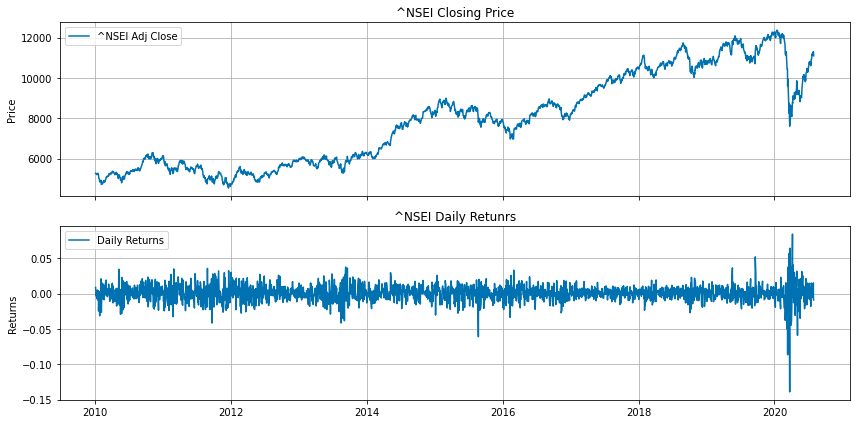

In [6]:
# visualize the closing price and daily returns
fig, ax = plt.subplots(2, 1, sharex=True, figsize = (12,6))
ax[0].plot(stock[ticker], label = f'{ticker} Adj Close')
ax[0].set(title = f'{ticker} Closing Price', ylabel = 'Price')
ax[0].grid(True)
ax[0].legend()

ax[1].plot(stock['returns'], label = 'Daily Returns')
ax[1].set(title = f'{ticker} Daily Retunrs', ylabel = 'Returns')
ax[1].grid(True)
plt.legend()

plt.tight_layout();
# plt.savefig('images/chart1', dpi=300)

In [7]:
# define the number of lags
lags = [1, 2, 3, 4, 5]
# compute lagged log returns
cols = []
for lag in lags:
    col = f'rtn_lag{lag}'
    stock[col] = stock['returns'].shift(lag)
    cols.append(col)

stock.dropna(inplace=True)
stock.head()

,^NSEI,returns,direction,rtn_lag1,rtn_lag2,rtn_lag3,rtn_lag4,rtn_lag5
Date,,,,,,,,
2010-01-12,5210.399902,-0.007457,-1,0.000886,-0.003493,-0.003547,0.000739,0.008696
2010-01-13,5233.950195,0.004510,1,-0.007457,0.000886,-0.003493,-0.003547,0.000739
2010-01-14,5259.899902,0.004946,1,0.004510,-0.007457,0.000886,-0.003493,-0.003547
2010-01-15,5252.200195,-0.001465,-1,0.004946,0.004510,-0.007457,0.000886,-0.003493
2010-01-18,5274.850098,0.004303,1,-0.001465,0.004946,0.004510,-0.007457,0.000886


In [8]:
# function to transform the lag returns to binary values (0,+1)
def create_bins(data, bins=[0]):
    global cols_bin
    cols_bin = []
    for col in cols:
        col_bin = col + '_bin'
        data[col_bin] = np.digitize(data[col], bins=bins)  
        cols_bin.append(col_bin)

create_bins(stock)
stock.head()

,^NSEI,returns,direction,rtn_lag1,rtn_lag2,rtn_lag3,rtn_lag4,rtn_lag5,rtn_lag1_bin,rtn_lag2_bin,rtn_lag3_bin,rtn_lag4_bin,rtn_lag5_bin
Date,,,,,,,,,,,,,
2010-01-12,5210.399902,-0.007457,-1,0.000886,-0.003493,-0.003547,0.000739,0.008696,1,0,0,1,1
2010-01-13,5233.950195,0.004510,1,-0.007457,0.000886,-0.003493,-0.003547,0.000739,0,1,0,0,1
2010-01-14,5259.899902,0.004946,1,0.004510,-0.007457,0.000886,-0.003493,-0.003547,1,0,1,0,0
2010-01-15,5252.200195,-0.001465,-1,0.004946,0.004510,-0.007457,0.000886,-0.003493,1,1,0,1,0
2010-01-18,5274.850098,0.004303,1,-0.001465,0.004946,0.004510,-0.007457,0.000886,0,1,1,0,1


In [9]:
# create a dictionary of selected algorithms
models = {
 'log_reg': linear_model.LogisticRegression(),
 'gauss_nb': GaussianNB(),
 'svm': SVC(),
 'random_forest': RandomForestClassifier(max_depth=10, n_estimators=100),
 'MLP' : MLPClassifier(max_iter=500),
}

In [10]:
# function that fits all models.
def fit_models(data):  
    mfit = {model: models[model].fit(data[cols_bin], data['direction']) for model in models.keys()}

In [11]:
# function that predicts (derives all position values) from the fitted models
def derive_positions(data):  
    for model in models.keys():
        data['pos_' + model] = models[model].predict(data[cols_bin])

In [12]:
# function to evaluate all trading strategies
def evaluate_strats(data):  
    global strategy_rtn
    strategy_rtn = []
    for model in models.keys():
        col = 'strategy_' + model 
        data[col] = data['pos_' + model] * data['returns']
        strategy_rtn.append(col)
    strategy_rtn.insert(0, 'returns')

In [13]:
# fit the models
fit_models(stock)

In [14]:
# derives all position values
derive_positions(stock)

In [15]:
evaluate_strats(stock)

In [16]:
stock.head(3)

,^NSEI,returns,direction,rtn_lag1,rtn_lag2,rtn_lag3,rtn_lag4,rtn_lag5,rtn_lag1_bin,rtn_lag2_bin,...,pos_log_reg,pos_gauss_nb,pos_svm,pos_random_forest,pos_MLP,strategy_log_reg,strategy_gauss_nb,strategy_svm,strategy_random_forest,strategy_MLP
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-12,5210.399902,-0.007457,-1,0.000886,-0.003493,-0.003547,0.000739,0.008696,1,0,...,1,1,1,1,1,-0.007457,-0.007457,-0.007457,-0.007457,-0.007457
2010-01-13,5233.950195,0.004510,1,-0.007457,0.000886,-0.003493,-0.003547,0.000739,0,1,...,1,1,1,1,1,0.004510,0.004510,0.004510,0.004510,0.004510
2010-01-14,5259.899902,0.004946,1,0.004510,-0.007457,0.000886,-0.003493,-0.003547,1,0,...,1,0,1,1,1,0.004946,0.000000,0.004946,0.004946,0.004946


In [17]:
# calculate total return and std. deviation of each strategy
print('\nTotal Returns: \n')
print(stock[strategy_rtn].sum().apply(np.exp))
print('\nAnnual Volitility:')
stock[strategy_rtn].std() * 252 ** 0.5 #WTF das hat keinen Sinn


Total Returns: 

returns                   2.114937
strategy_log_reg          2.262539
strategy_gauss_nb         1.846504
strategy_svm              8.130174
strategy_random_forest    9.039251
strategy_MLP              7.404331
dtype: float64

Annual Volitility:


returns                   0.177052
strategy_log_reg          0.177041
strategy_gauss_nb         0.128357
strategy_svm              0.176642
strategy_random_forest    0.176594
strategy_MLP              0.176683
dtype: float64

In [18]:
# number of trades over time for highest and second highest return strategy
print('Number of trades SVM = ', (stock['pos_svm'].diff()!=0).sum())
print('Number of trades Ramdom Forest = ',(stock['pos_random_forest'].diff()!=0).sum())

Number of trades SVM =  1045
Number of trades Ramdom Forest =  1015


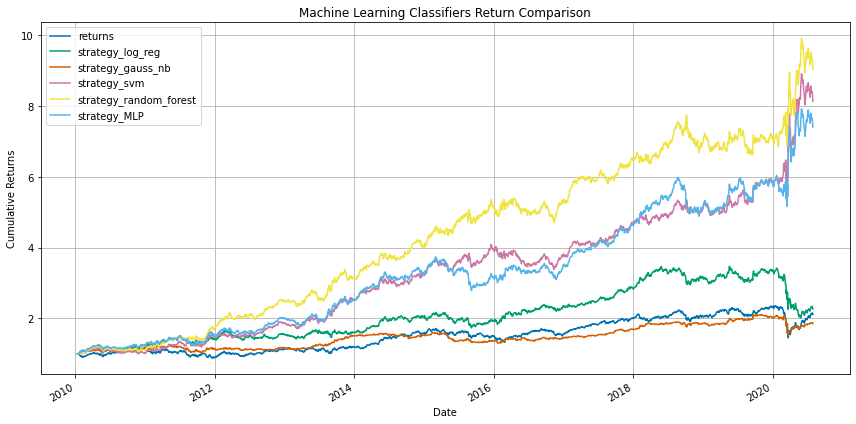

In [19]:
# vectorized backtesting of the resulting trading strategies and visualize the performance over time
ax = stock[strategy_rtn].cumsum().apply(np.exp).plot(figsize=(12, 6), 
                                                     title = 'Machine Learning Classifiers Return Comparison')
ax.set_ylabel("Cumulative Returns")
ax.grid(True);
plt.tight_layout();

In [20]:
# fetch the daily pricing data from yahoo finance
prices = yf.download(ticker, progress=True, actions=True, start=start, end=end)
prices.head(2)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits
Date,,,,,,,,
2010-01-04,5200.899902,5238.450195,5167.100098,5232.200195,5232.200195,0,0,0
2010-01-05,5277.149902,5288.350098,5242.399902,5277.899902,5277.899902,0,0,0


In [21]:
# rename the columns as needed for Backtrader
prices.drop(['Close','Dividends','Stock Splits'], inplace=True, axis=1)
prices.rename(columns = {'Open':'open','High':'high','Low':'low','Adj Close':'close','Volume':'volume',
                         }, inplace=True)
prices.head(3)

,open,high,low,close,volume
Date,,,,,
2010-01-04,5200.899902,5238.450195,5167.100098,5232.200195,0
2010-01-05,5277.149902,5288.350098,5242.399902,5277.899902,0
2010-01-06,5278.149902,5310.850098,5260.049805,5281.799805,0


In [22]:
# add the predicted column to prices dataframe. This will be used as signal for buy or sell
predictions = stock['strategy_svm']
predictions = pd.DataFrame(predictions)
predictions.rename(columns = {'strategy_svm':'predicted'}, inplace=True)
prices = predictions.join(prices, how='right').dropna()
prices.head(2)
OHLCV = ['open', 'high', 'low', 'close', 'volume']


In [23]:
# class to define the columns we will provide
class SignalData(PandasData):
    """
    Define pandas DataFrame structure
    """
    cols = OHLCV + ['predicted']
    # create lines
    lines = tuple(cols)
    # define parameters
    params = {c: -1 for c in cols}
    params.update({'datetime': None})
    params = tuple(params.items())

In [31]:
# define backtesting strategy class
class MLStrategy(bt.Strategy):
    params = dict(
    )
    
    def __init__(self):
        # keep track of open, close prices and predicted value in the series
        self.data_predicted = self.datas[0].predicted
        self.data_open = self.datas[0].open
        self.data_close = self.datas[0].close
        
        # keep track of pending orders/buy price/buy commission
        self.order = None
        self.price = None
        self.comm = None
    # logging function
    def log(self, txt):
        '''Logging function'''
        dt = self.datas[0].datetime.date(0).isoformat()
        print(f'{dt}, {txt}')
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # order already submitted/accepted - no action required
            return
        # report executed order
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'BUY EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f},Commission: {order.executed.comm:.2f}'
                )
                self.price = order.executed.price
                self.comm = order.executed.comm
            else:
                self.log(f'SELL EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f},Commission: {order.executed.comm:.2f}'
                )
        # report failed order
        elif order.status in [order.Canceled, order.Margin, 
                              order.Rejected]:
            self.log('Order Failed')
        # set no pending order
        self.order = None
    def notify_trade(self, trade):
        if not trade.isclosed:
            return
        self.log(f'OPERATION RESULT --- Gross: {trade.pnl:.2f}, Net: {trade.pnlcomm:.2f}')
    # We have set cheat_on_open = True.This means that we calculated the signals on day t's close price, 
    # but calculated the number of shares we wanted to buy based on day t+1's open price.
    def next_open(self):
        if not self.position:
            if self.data_predicted > 0:
                # calculate the max number of shares ('all-in')
                size = int(self.broker.getcash() / self.datas[0].open)
                # buy order
                self.log(f'BUY CREATED --- Size: {size}, Cash: {self.broker.getcash():.2f}, Open: {self.data_open[0]}, Close: {self.data_close[0]}')
                self.buy(size=size)
        else:
            if self.data_predicted < 0:
                # sell order
                self.log(f'SELL CREATED --- Size: {self.position.size}')
                self.sell(size=self.position.size)
                

In [32]:
# instantiate SignalData class
data = SignalData(dataname=prices)
# instantiate Cerebro, add strategy, data, initial cash, commission and pyfolio for performance analysis
cerebro = bt.Cerebro(stdstats = False, cheat_on_open=True)
cerebro.addstrategy(MLStrategy)
cerebro.adddata(data, name=ticker)
cerebro.broker.setcash(100000.0)
cerebro.broker.setcommission(commission=0.001)
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
# run the backtest
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
backtest_result = cerebro.run()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 100000.00
2010-01-13, BUY CREATED --- Size: 19, Cash: 100000.00, Open: 5212.60009765625, Close: 5233.9501953125
2010-01-13, BUY EXECUTED --- Price: 5212.60, Cost: 99039.40,Commission: 99.04
2010-01-15, SELL CREATED --- Size: 19
2010-01-15, SELL EXECUTED --- Price: 5259.90, Cost: 99039.40,Commission: 99.94
2010-01-15, OPERATION RESULT --- Gross: 898.70, Net: 699.72
2010-01-18, BUY CREATED --- Size: 19, Cash: 100699.72, Open: 5253.64990234375, Close: 5274.85009765625
2010-01-18, BUY EXECUTED --- Price: 5253.65, Cost: 99819.35,Commission: 99.82
2010-01-19, SELL CREATED --- Size: 19
2010-01-19, SELL EXECUTED --- Price: 5274.20, Cost: 99819.35,Commission: 100.21
2010-01-19, OPERATION RESULT --- Gross: 390.46, Net: 190.43
2010-01-20, BUY CREATED --- Size: 19, Cash: 100890.15, Open: 5226.10009765625, Close: 5221.7001953125
2010-01-20, BUY EXECUTED --- Price: 5226.10, Cost: 99295.90,Commission: 99.30
2010-01-28, SELL CREATED --- Size: 19
2010-01-28, SELL EXECUTED --- 